Trying [lambda cloud](cloud.lambda.ai)

Made an account and added credit card and billing info.

Want to try first with a ~$0.50 / hour one like I was using on paperspace but those all show out of capacity.

What's the difference between SXM5 and PCIe? I'll go with 1x H100 80 GB SXM5.

Only 2 regions available. Going with us-south-2

Unsure which base image to use. Will go with default: Lambda Stack 22.04

Filesystem seems much more expensive than paperspace...or am I calculating wrong?

Created filesystem: mynanochat

Did not create firewall rules

Booting...said it could take 10 minutes. Tooks less. Maybe 2 miutes?

#### make base_dir configurable

To fit with where the storage is mounted on lambda cloud 

Try on my laptp still:

In [1]:
!pwd

/Users/ericsilberstein/Documents/ericsilberstein1-repos/nanogpt-learning/challenge-25-pretrain-d20


In [2]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_common import get_base_dir

In [3]:
get_base_dir()

'/Users/ericsilberstein/.cache/my_nanochat'

In [10]:
import os
os.environ['NANOCHAT_BASE_DIR'] = os.getcwd()
get_base_dir()

'/Users/ericsilberstein/Documents/ericsilberstein1-repos/nanogpt-learning/challenge-25-pretrain-d20'

### Instructions

I started with the instructions in `getting-ready.ipynb` and updated to work with the lambda cloud machine.

```
ssh ssh ubuntu@[ip]

# ssh key for git
ssh-keygen -t ed25519 -C "lambda-cloud"
cat ~/.ssh/id_ed25519.pub
copy into github UI (https://github.com/settings/keys)

git config --global user.email "ericsilberstein@gmail.com"
git config --global user.name "Eric Silberstein"

# clone this repo
git clone git@github.com:ericsilberstein1/nanogpt-learning.git


# looks like not needed on lambda cloud, prob already there
# later, after working on challenge 15, looked into why torch was failing to compile the model
# and realized needed to do this so python headers get installed
# the specific error was: /tmp/tmp0normshd/cuda_utils.c:6:10: fatal error: Python.h: No such file 
# or directory 6 | #include <Python.h>
#sudo apt-get install python3.10-dev

# UV
curl -LsSf https://astral.sh/uv/install.sh | sh

# rust
curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh
echo '. "$HOME/.cargo/env"' >> .bashrc

echo 'export NANOCHAT_BASE_DIR="/home/ubuntu/mynanochat"' >> .bashrc

# in .bashrc add
# export WANDB_API_KEY="XXX"

source .bashrc

cd nanogpt-learning

uv sync
source .venv/bin/activate

# for now until organize this better
uv tool install maturin
cd challenge-07-rust-and-python-simplified-tokenizer/rust_tokenizer
maturin develop
cd -

# download data files
PYTHONPATH=my_nanochat python -m my_nanochat.my_dataset --num-files 8

# download another 240 in the background, check this completes before starting base_train
PYTHONPATH=my_nanochat python -m my_nanochat.my_dataset --num-files 240 &

# in challenge 23 I created my_tok_train.py so now can train the tokenizer here rather
# than from a notebook
PYTHONPATH=my_nanochat python -m scripts.my_tok_train

# looks like lambda automatically runs jupyter but for now at least let me run it
# in the way I understand
uv run jupyter lab --port=7001
jupyter server list

# ON MY LAPTOP make port 8889 a tunnel to jupyter
ssh -N -L 7001:localhost:7001 ubuntu@[ip]
```

### now on the lambda cloud machine

In [1]:
!nvidia-smi

Sun Nov 16 12:54:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.148.08             Driver Version: 570.148.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:07:00.0 Off |                    0 |
| N/A   31C    P0             75W /  700W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import sys
sys.path.append('../my_nanochat')
from my_nanochat.my_common import get_base_dir

In [4]:
get_base_dir()

'/home/ubuntu/mynanochat'

I'm waiting for the tokenizer to train. It's taking a really long time and it's up to 270 buffers. I wonder if the last time I built one which also aimed for the default of 10B characters I hadn't yet downloaded more than 8 data files and so it really never got to the full 10B? It eventually filled 325 buffers.

Try a run with our one GPU and only 100 iterations but otherwise letting the defaults decide sequence length, batch size per device, etc. (This makes me realize I should copy the logic to determine number of iterations based on target param ratio before doing the bigger run.)

In tmux shell:

```
source .venv/bin/activate

cd challenge-25-pretrain-d20

export PYTHONPATH=../my_nanochat/

torchrun --standalone --nproc_per_node=1 -m scripts.my_base_train -- --depth=20 --num_iterations=100 --eval_every=50 --core_metric_every=50 --core_metric_max_per_task=50 --sample_every=50 --run=challenge-25-1 > train_output_001.txt 2>&1
```

ok, it's running! Now getting to ~140,000 tokens per second. Big step up from the ~5,000 with 2 RTX 4000s.

In [5]:
!tail -50 train_output_001.txt

Evaluating: bigbench_cs_algorithms (10-shot, type: language_modeling)... accuracy: 0.0600 | centered: 0.0600 | time: 0.48s
Evaluating: bigbench_operators (10-shot, type: language_modeling)... accuracy: 0.0800 | centered: 0.0800 | time: 0.46s
Evaluating: bigbench_repeat_copy_logic (10-shot, type: language_modeling)... accuracy: 0.0000 | centered: 0.0000 | time: 0.30s
Evaluating: squad (10-shot, type: language_modeling)... accuracy: 0.0000 | centered: 0.0000 | time: 0.83s
Evaluating: coqa (0-shot, type: language_modeling)... accuracy: 0.0000 | centered: 0.0000 | time: 0.53s
Evaluating: boolq (10-shot, type: multiple_choice)... accuracy: 0.4000 | centered: -0.5789 | time: 1.17s
Evaluating: bigbench_language_identification (10-shot, type: multiple_choice)... accuracy: 0.2800 | centered: 0.2079 | time: 1.84s
Step 00100: CORE metric: -0.0412
<|bos|>The capital of France is the most of the most of the most of the
<|bos|>The chemical symbol of gold is a symbol of the term of the term used in
<

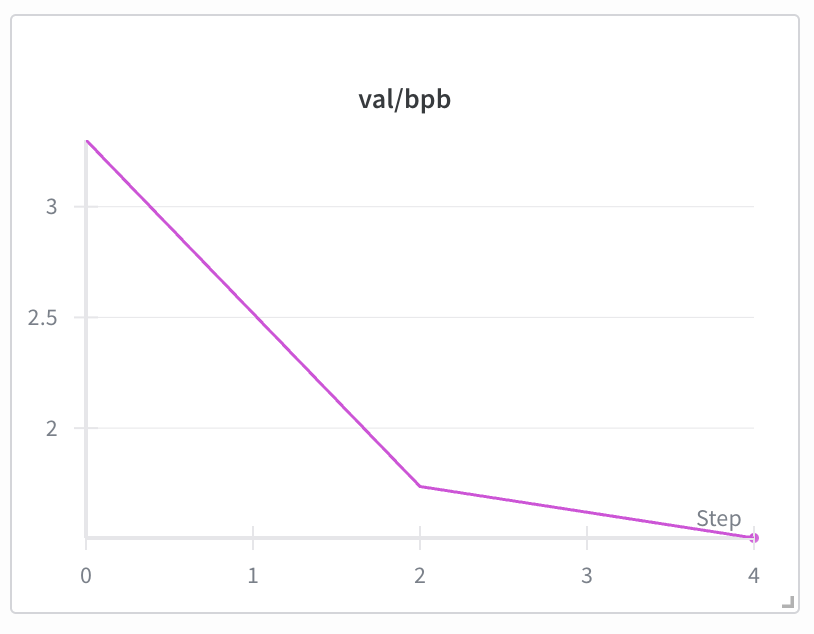

Make sure can load from checkpoint

In [8]:
!ls -lh /home/ubuntu/mynanochat/base_checkpoints/d20/

total 4.4G
-rw-rw-r-- 1 ubuntu ubuntu  805 Nov 16 13:51 meta_000100.json
-rw-rw-r-- 1 ubuntu ubuntu 2.0G Nov 16 13:51 model_000100.pt
-rw-rw-r-- 1 ubuntu ubuntu 2.5G Nov 16 13:51 optim_000100_rank0.pt


In [6]:
import sys
sys.path.append('../my_nanochat')
import os
import torch
from my_nanochat.my_common import get_base_dir, autodetect_device_type
from my_nanochat.my_checkpoint_manager import build_model
device_type = autodetect_device_type()
device = torch.device(device_type)
autocast_ctx = torch.amp.autocast(device_type=device_type, dtype=torch.bfloat16) if device_type == "cuda" else nullcontext()

Autodetected device type: cuda


In [7]:
checkpoint_dir = os.path.join(get_base_dir(), "base_checkpoints", "d20")
model, tokenizer, meta_data = build_model(checkpoint_dir, step=100, device=device, phase="eval")

Building model with config: {'sequence_len': 2048, 'vocab_size': 65536, 'n_layer': 20, 'n_head': 10, 'n_kv_head': 10, 'n_embd': 1280}


In [9]:
with autocast_ctx:
    tokens = list(model.generate(tokenizer.encode("First take a right on Main St.", prepend=tokenizer.get_bos_token_id()), max_tokens=10))
tokens

[2177, 17299, 283, 624, 4236, 2091, 257, 879, 44, 550]

In [10]:
tokenizer.decode(tokens)

' John feared in his drive toward a car, one'

I believe I'll hold onto this filesystem for a bit, but just in case, download tokenizer to my laptop:

```
mkdir tokenizer-from-challenge-25
cd tokenizer-from-challenge-25
scp ubuntu@[ip]:/home/ubuntu/mynanochat/my-tokenizer.pkl .
scp ubuntu@[ip]:/home/ubuntu/mynanochat/token_bytes.pt .
```

#### confirm determine number of iterations based on target param data ratio works

I'll cancel this, just want to confirm it starts.

In tmux shell:

```
torchrun --standalone --nproc_per_node=1 -m scripts.my_base_train -- --depth=20 --target_param_data_ratio=1 --run=challenge-25-2 > train_output_002.txt 2>&1
```

In [6]:
!grep target_param_data_ratio train_output_002.txt

overriding target_param_data_ratio = 1
user_config: {'run': 'challenge-25-2', 'device_type': '', 'depth': 20, 'max_seq_len': 2048, 'num_iterations': -1, 'target_param_data_ratio': 1, 'device_batch_size': 32, 'total_batch_size': 524288, 'embedding_lr': 0.2, 'unembedding_lr': 0.004, 'weight_decay': 0.0, 'matrix_lr': 0.02, 'grad_clip': 1.0, 'warmup_ratio': 0.0, 'warmdown_ratio': 0.2, 'final_lr_frac': 0.0, 'eval_every': 250, 'eval_tokens': 10485760, 'core_metric_every': 2000, 'core_metric_max_per_task': 500, 'sample_every': 2000, 'model_tag': ''}
Calculated num iterations from target_param_data_ratio as 1,070


In [7]:
!cat train_output_002.txt

overriding depth = 20
overriding target_param_data_ratio = 1
overriding run = challenge-25-2
user_config: {'run': 'challenge-25-2', 'device_type': '', 'depth': 20, 'max_seq_len': 2048, 'num_iterations': -1, 'target_param_data_ratio': 1, 'device_batch_size': 32, 'total_batch_size': 524288, 'embedding_lr': 0.2, 'unembedding_lr': 0.004, 'weight_decay': 0.0, 'matrix_lr': 0.02, 'grad_clip': 1.0, 'warmup_ratio': 0.0, 'warmdown_ratio': 0.2, 'final_lr_frac': 0.0, 'eval_every': 250, 'eval_tokens': 10485760, 'core_metric_every': 2000, 'core_metric_max_per_task': 500, 'sample_every': 2000, 'model_tag': ''}
Autodetected device type: cuda
/home/ubuntu/nanogpt-learning/.venv/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_t

^ looks good